In [1]:
#Basic Libraries
%matplotlib inline
import requests
import sys
import os
from itertools import islice
import re
from bs4 import BeautifulSoup
import json
import pandas as pd
from time import sleep
import string
from collections import Counter

#Music APIs
import pygn
import spotipy
import spotipy.util as util
import billboard as bb
import pylast
from songkick import Songkick
import discogs_client
import musicbrainzngs as mb
import pytrends
from pytrends.request import TrendReq

In [2]:
all_data = pd.read_csv('artist_data.csv').drop(['Unnamed: 0'], axis=1)

In [3]:
# Stats Libraries
import seaborn as sns
from sklearn import linear_model as lm
from sklearn import feature_selection as f_select
from sklearn import cross_validation as cv
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import statsmodels.formula.api as smf

In [4]:
### STATSMODELS ###

# create a fitted model
sm_lm = smf.ols(formula='played_warped ~ gracenote_era + member_count + spotify_popularity + spotify_track_popularity + acousticness + danceability + duration_ms + energy + instrumentalness + key + liveness + loudness + mode + speechiness + tempo + time_signature + valence + lastfm_play_count + lastfm_listener_count', data=all_data).fit()

In [5]:
### Spotify Settings: https://developer.spotify.com/web-api/ ###

os.environ["SPOTIPY_CLIENT_ID"] = "ENTER SPOTIFY CLIENT ID"
os.environ["SPOTIPY_CLIENT_SECRET"] = "ENTER SPOTIFY SECRET KEY"
os.environ["SPOTIPY_REDIRECT_URI"] = "ENTER REDIRECT URI"

scopes = 'playlist-read-private playlist-read-collaborative playlist-modify-public playlist-modify-private user-follow-modify user-follow-read user-library-read user-library-modify user-read-private user-read-birthdate user-read-email user-top-read'
spotify_username = sys.argv[1]
token = util.prompt_for_user_token(spotify_username, scopes)
sp = spotipy.Spotify(auth=token)

In [6]:
### Last.FM Settings: http://www.last.fm/api ###

LASTFM_API_KEY = "ENTER LAST FM API KEY"
LASTFM_API_SECRET = "ENTER LAST FM SECRET KEY"
lastfm_username = 'ENTER LAST FM USERNAME'
lastfm_password_hash = pylast.md5("ENTER LAST FM PASSWORD")
lastfm = pylast.LastFMNetwork(api_key=LASTFM_API_KEY, api_secret=LASTFM_API_SECRET, username=lastfm_username, password_hash=lastfm_password_hash)

In [7]:
### Music Brainz Settings: https://musicbrainz.org/doc/Development ###
mb.set_useragent("ENTER MUSICBRAINZ PROJECT NAME", "0.1", "ENTER MUSICBRAINZ PROJECT URL")

In [8]:
### Gracenote Settings: https://developer.gracenote.com/web-api ###
clientID = 'ENTER GRACENOTE CLIENT ID'
userID = 'ENTER GRACENOTE USER ID'

In [9]:
test_artists = ['Blink-182', 'Taking Back Sunday', 'Korn', 'Panic! At The Disco', 'The Cure', 'Fall Out Boy']

In [10]:
# define X and y
feature_cols = list(all_data.describe().columns)[:-1]
X = all_data[feature_cols]
y = all_data.played_warped

In [11]:
# get spotify id & musicbrainz id
def get_ids(band1):
        sp_artist_search = sp.search(q=band1, limit=1, type='artist')
        if 'Error' not in sp_artist_search: 
            try:
                yield sp_artist_search['artists']['items'][0]['id']
            except:
                yield '0'
        musicbrain_artist_search = mb.search_artists(query=band1, limit=1)
        if 'Error' not in musicbrain_artist_search: 
            try:
                yield musicbrain_artist_search['artist-list'][0]['id']
            except:
                yield '0'

# get gracenote era
def gn_era(band1):
    try:
        gracenote_artist_search = pygn.search(clientID=clientID, userID=userID, artist=band1)
        return gracenote_artist_search['artist_era']['1']['TEXT']
    except:
        return ('0')
    
# get number of members from musicbrainz
def mb_members(gn_id):
    try:
        musicbrain_id_search = mb.get_artist_by_id(gn_id, includes=['artist-rels'])
        for item in musicbrain_id_search['artist']['artist-relation-list']:
                yield item['artist']['name']
    except:
        yield('0')

#get spotify artist popularity & genre
def sp_popularity_genre(sp_id):
    try:
        spotify_id_search = sp.artist(sp_id)
        return spotify_id_search['popularity'], spotify_id_search['genres'][0]
    except:
        return ('0','0')

#get lastfm popularity:
def lastfm_counts(gn_id):
    try:
        lastfm_artist_id_search = lastfm.get_artist_by_mbid(gn_id)
        return lastfm_artist_id_search.get_playcount(), lastfm_artist_id_search.get_listener_count()
    except:
        return('0', '0')

# get spotify artist top track ids
def spotify_top_tracks(sp_id):
    try:
        spotify_top_tracks_search = sp.artist_top_tracks(sp_id, country='US')['tracks']
        if 'Error' not in spotify_top_tracks_search:
            for tracks in spotify_top_tracks_search:
                yield tracks['id']
    except:
        yield '0'

# get spotify artist top track popularity
def spotify_top_tracks_popularity(sp_id):
    try:
        spotify_top_tracks_search = sp.artist_top_tracks(sp_id, country='US')['tracks']
        if 'Error' not in spotify_top_tracks_search:
            for tracks in spotify_top_tracks_search:
                yield tracks['popularity']
    except:
        yield '0'

# get spotify artist top track attributes
def spotify_top_tracks_attributes(tracks):
    acousticness = []
    danceability = []
    duration_ms = [] 
    energy = [] 
    instrumentalness = []
    key = []
    liveness = [] 
    loudness = []
    mode = []
    speechiness = [] 
    tempo = [] 
    time_signature = [] 
    valence = []
    spotify_tracks_search = sp.audio_features(tracks)
    try:
        if 'Error' not in spotify_tracks_search:
            for tracks in spotify_tracks_search:
                acousticness.append(tracks['acousticness'])
                danceability.append(tracks['danceability'])
                duration_ms.append(tracks['duration_ms'])
                energy.append(tracks['energy'])
                instrumentalness.append(tracks['instrumentalness'])
                key.append(tracks['key'])
                liveness.append(tracks['liveness'])
                loudness.append(tracks['loudness'])
                mode.append(tracks['mode'])
                speechiness.append(tracks['speechiness'])
                tempo.append(tracks['tempo'])
                time_signature.append(tracks['time_signature'])
                valence.append(tracks['valence'])
            yield sum(acousticness)/len(acousticness), sum(danceability)/len(danceability), sum(duration_ms)/len(duration_ms), sum(energy)/len(energy), sum(
                instrumentalness)/len(instrumentalness), sum(key)/len(key), sum(liveness)/len(liveness), sum(
                loudness)/len(loudness),sum(mode)/len(mode), sum(speechiness)/len(speechiness), sum(tempo)/len(tempo), sum(
                time_signature)/len(time_signature), sum(valence)/len(valence)
    except:
        yield zeros23[0:12]


In [28]:
def get_data2(band5):
    band5_name = band5
    band5_spotify_id = list(get_ids(band5))[0]
    band5_musicbrainz_id = list(get_ids(band5))[1]
    band5_era = int(gn_era(band5)[0:4])
    band5_member_count = len(set(mb_members(list(get_ids(band5))[1])))
    band5_popularity = sp_popularity_genre(list(get_ids(band5))[0])[0]
    band5_genre = sp_popularity_genre(list(get_ids(band5))[0])[1]
    band5_populary_tracks_avg = sum(list(spotify_top_tracks_popularity(list(get_ids(band5))[0])))/len(list(spotify_top_tracks_popularity(list(get_ids(band5))[0])))
    band5_acousticness = list(spotify_top_tracks_attributes(spotify_top_tracks(list(get_ids(band5))[0])))[0][0]
    band5_danceability = list(spotify_top_tracks_attributes(spotify_top_tracks(list(get_ids(band5))[0])))[0][1]
    band5_duration_ms = list(spotify_top_tracks_attributes(spotify_top_tracks(list(get_ids(band5))[0])))[0][2]
    band5_energy = list(spotify_top_tracks_attributes(spotify_top_tracks(list(get_ids(band5))[0])))[0][3] 
    band5_instrumentalness = list(spotify_top_tracks_attributes(spotify_top_tracks(list(get_ids(band5))[0])))[0][4]
    band5_key = list(spotify_top_tracks_attributes(spotify_top_tracks(list(get_ids(band5))[0])))[0][5]
    band5_liveness = list(spotify_top_tracks_attributes(spotify_top_tracks(list(get_ids(band5))[0])))[0][6]
    band5_loudness = list(spotify_top_tracks_attributes(spotify_top_tracks(list(get_ids(band5))[0])))[0][7]
    band5_mode = list(spotify_top_tracks_attributes(spotify_top_tracks(list(get_ids(band5))[0])))[0][8]
    band5_speechiness = list(spotify_top_tracks_attributes(spotify_top_tracks(list(get_ids(band5))[0])))[0][9]
    band5_tempo = list(spotify_top_tracks_attributes(spotify_top_tracks(list(get_ids(band5))[0])))[0][10]
    band5_time_signature = list(spotify_top_tracks_attributes(spotify_top_tracks(list(get_ids(band5))[0])))[0][11]
    band5_valence = list(spotify_top_tracks_attributes(spotify_top_tracks(list(get_ids(band5))[0])))[0][12]
    band5_lastfm_play_count = lastfm_counts(list(get_ids(band5))[1])[0]
    band5_lastfm_listener_count = lastfm_counts(list(get_ids(band5))[1])[1]
    band5_search = [band5_era, band5_member_count, band5_popularity,  band5_populary_tracks_avg, band5_acousticness, 
                    band5_danceability, band5_duration_ms, band5_energy, band5_instrumentalness, band5_key, 
                    band5_liveness, band5_loudness, band5_mode, band5_speechiness, band5_tempo, 
                    band5_time_signature, band5_valence, band5_lastfm_play_count, band5_lastfm_listener_count]
    band5_search_pd = pd.DataFrame(band5_search).transpose()
    band5_search_pd.columns = all_data.describe().columns[:-1]
    if round(sm_lm.predict(band5_search_pd),0) == 0:
        print band5 + ' is not likely to play Warped Tour.'
    else:
        print band5 + ' is likely to play Warped Tour!'
    return band5_search_pd

In [29]:
get_data2('Blink-182')

Blink-182 is likely to play Warped Tour!


,gracenote_era,member_count,spotify_popularity,spotify_track_popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,lastfm_play_count,lastfm_listener_count
0,1990.0,5.0,81.0,67.0,0.009924,0.4904,186004.0,0.8759,0.000009,3.0,0.23087,-4.8564,1.0,0.06807,136.2899,4.0,0.5502,162957491.0,2811137.0


In [14]:
get_data2('Korn')

Korn is not likely to play Warped Tour.


In [15]:
### Describe Data ###

all_data.describe()

,gracenote_era,member_count,spotify_popularity,spotify_track_popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,lastfm_play_count,lastfm_listener_count,played_warped
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,4.200000e+02,4.200000e+02,420.000000
mean,1827.261905,1.997619,47.021429,36.036614,0.088497,0.485118,209273.640291,0.787645,0.055169,5.013029,0.209107,-5.214856,0.525265,0.090169,126.795459,3.766243,0.443311,1.168587e+07,2.891402e+05,0.776190
std,568.654886,2.893907,20.857787,17.651959,0.125192,0.139233,49337.047089,0.190146,0.118723,1.499489,0.077679,2.124877,0.349941,0.052427,25.715974,0.705721,0.172109,3.238140e+07,4.965200e+05,0.417293
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-20.585900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,2000.000000,0.000000,35.750000,24.275000,0.006445,0.415800,194693.150000,0.731075,0.000056,4.200000,0.162757,-6.048950,0.200000,0.055810,119.995725,3.900000,0.336075,4.178188e+05,2.228700e+04,1.000000
50%,2000.000000,1.000000,51.000000,38.800000,0.048686,0.479350,212608.650000,0.846400,0.002250,5.050000,0.202990,-4.885200,0.600000,0.078370,130.044400,4.000000,0.444500,2.707704e+06,1.119410e+05,1.000000
75%,2010.000000,4.000000,61.250000,49.000000,0.109498,0.571700,231531.425000,0.914300,0.061674,6.000000,0.248805,-4.125600,0.800000,0.114827,139.563475,4.000000,0.567675,1.067752e+07,3.221592e+05,1.000000
max,2010.000000,25.000000,91.000000,80.000000,0.982200,0.870000,364586.000000,0.990700,0.907400,9.000000,0.714000,0.000000,1.000000,0.325720,166.244400,4.300000,0.946400,4.520452e+08,4.520061e+06,1.000000


In [16]:
### Set Test, Train, Split ###

x_train, x_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.333, random_state=1234)


linear_model = lm.LinearRegression().fit(x_train, y_train)
logistic_model = lm.LogisticRegression().fit(x_train, y_train)
dt_model = DecisionTreeClassifier(max_depth=3, random_state=1).fit(x_train, y_train)
knn_model = KNeighborsClassifier(5).fit(x_train, y_train)

treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
clf = treeclf.fit(X, y)

In [17]:
linreg = lm.LinearRegression()
lin_scores = cross_val_score(linreg, X, y, scoring='mean_squared_error')
#lin_accuracy = cross_val_score(linreg, X, y, scoring='accuracy')
print 'Linear Regression Scoring Mean Squared:'
print np.mean(np.sqrt(-lin_scores))
print ''
#print 'Linear Regression Mean Accuracy:'
#print np.mean(lin_accuracy)
#print ''

logreg = LogisticRegression()
log_scores = cross_val_score(logreg, X, y, cv=10, scoring='mean_squared_error')
log_accuracy = cross_val_score(logreg, X, y, cv=14, scoring='accuracy')
print 'Logistic Regression Scoring Mean Squared Error:'
print np.mean(np.sqrt(-log_scores))
print ''
print 'Logistic Regression Mean Accuracy:'
print np.mean(log_accuracy)
print ''


dt_scores = cross_val_score(treeclf, X, y, cv=14, scoring='mean_squared_error')
dt_accuracy = cross_val_score(treeclf, X, y, cv=14, scoring='accuracy')
print 'Decision Tree Root Mean Squared Error'
print np.mean(np.sqrt(-dt_scores))
print ''

print 'Decision Tree Mean Accuracy'
print np.mean(dt_accuracy)
print ''

knn = KNeighborsClassifier(5)
knn_scores = cross_val_score(knn, X, y, cv=10, scoring='mean_squared_error') 
knn_accuracy = cross_val_score(knn, X, y, cv=10, scoring='accuracy')

print 'KNN Mean Accuracy'
print np.mean(np.sqrt(-knn_scores))
print ''
print 'KNN Root Mean Squared Error'
print np.mean(knn_accuracy)


Linear Regression Scoring Mean Squared:
0.425836015364

Logistic Regression Scoring Mean Squared Error:
0.519928931156

Logistic Regression Mean Accuracy:
0.709425817045

Decision Tree Root Mean Squared Error
0.123977925841

Decision Tree Mean Accuracy
0.965845648604

KNN Mean Accuracy
0.480986798669

KNN Root Mean Squared Error
0.766276368744


In [18]:
print 'LINEAR REGRESSION TRAIN MODEL SCORES (model/r^2)'
print linear_model.score(x_train, y_train)
print metrics.r2_score(y_train, linear_model.predict(x_train))
print ''

print 'LINEAR REGRESSION TEST MODEL SCORES (model/r^2)'
print linear_model.score(x_test, y_test)
print metrics.r2_score(y_test, linear_model.predict(x_test))
print ''

print 'LOGISTIC REGRESSION TRAIN MODEL SCORES (model/r^2)'
print logistic_model.score(x_train, y_train)
print metrics.r2_score(y_train, logistic_model.predict(x_train))
print ''

print 'LOGISTIC REGRESSION TEST MODEL SCORES (model/r^2)'
print logistic_model.score(x_test, y_test)
print metrics.r2_score(y_test, logistic_model.predict(x_test))
print ''

print 'DECISION TREE TRAIN MODEL SCORES (model/r^2)'
print dt_model.score(x_train, y_train)
print metrics.r2_score(y_train, dt_model.predict(x_train))
print ''

print 'DECISION TREE TEST MODEL SCORES (model/r^2)'
print dt_model.score(x_test, y_test)
print metrics.r2_score(y_test, dt_model.predict(x_test))
print ''

print 'KNN TRAIN MODEL SCORES (model/r^2)'
print knn_model.score(x_train, y_train)
print metrics.r2_score(y_train, knn_model.predict(x_train))
print ''

print 'KNN TEST MODEL SCORES (model/r^2)'
print knn_model.score(x_test, y_test)
print metrics.r2_score(y_test, knn_model.predict(x_test))
print ''

LINEAR REGRESSION TRAIN MODEL SCORES (model/r^2)
0.689662646986
0.689662646986

LINEAR REGRESSION TEST MODEL SCORES (model/r^2)
0.611597288673
0.611597288673

LOGISTIC REGRESSION TRAIN MODEL SCORES (model/r^2)
0.753571428571
-0.397569444444

LOGISTIC REGRESSION TEST MODEL SCORES (model/r^2)
0.778571428571
-0.315151515152

DECISION TREE TRAIN MODEL SCORES (model/r^2)
0.996428571429
0.97974537037

DECISION TREE TEST MODEL SCORES (model/r^2)
0.971428571429
0.830303030303

KNN TRAIN MODEL SCORES (model/r^2)
0.835714285714
0.068287037037

KNN TEST MODEL SCORES (model/r^2)
0.771428571429
-0.357575757576



In [19]:
print 'CONFUSION MATRIXES'
#Top Left: True Negatives
#Top Right False Positives
#Bottom Left: False Negatives
#Bottom Right: True Positives

#Do Sensitivity testing to identify overfitting
print ''

log_preds = logreg.fit(X,y).predict(X)
print 'LOGISTIC REGRESSION CONFUSION MATRIX'
print metrics.confusion_matrix(y, log_preds)
print ''

dt_preds = treeclf.predict(X)
print 'DECISION TREE CONFUSION MATRIX'
print metrics.confusion_matrix(y, dt_preds)
print ''

knn_preds = knn.fit(X,y).predict(X)
print 'KNN CONFUSION MATRIX'
print metrics.confusion_matrix(y, knn_preds)
print ''

CONFUSION MATRIXES

LOGISTIC REGRESSION CONFUSION MATRIX
[[  9  85]
 [ 10 316]]

DECISION TREE CONFUSION MATRIX
[[ 89   5]
 [  0 326]]

KNN CONFUSION MATRIX
[[ 37  57]
 [ 10 316]]



In [20]:
### Linear Regression Model Results ###

# print the coefficients
print 'LINEAR REGRESSION'
print ''

print 'Coefficients'
for key, value in dict(sm_lm.params).iteritems():
    print key, round(value,3)
print "\n"

#print p-values
print 'P-Values'
for key, value in dict(sm_lm.pvalues).iteritems():
    print key, round(value,3)
print "\n"

LINEAR REGRESSION

Coefficients
gracenote_era 0.0
member_count 0.006
lastfm_listener_count -0.0
time_signature 0.101
tempo -0.002
energy 0.308
liveness -0.597
spotify_track_popularity -0.014
speechiness 0.723
mode 0.662
acousticness 0.156
Intercept 0.896
danceability -0.477
key 0.018
duration_ms -0.0
loudness 0.026
spotify_popularity 0.008
valence -0.301
lastfm_play_count 0.0
instrumentalness -0.303


P-Values
gracenote_era 0.615
member_count 0.212
lastfm_listener_count 0.229
time_signature 0.019
tempo 0.022
energy 0.113
liveness 0.003
spotify_track_popularity 0.0
speechiness 0.012
mode 0.0
acousticness 0.337
Intercept 0.0
danceability 0.004
key 0.073
duration_ms 0.011
loudness 0.013
spotify_popularity 0.0
valence 0.013
lastfm_play_count 0.174
instrumentalness 0.01




In [21]:
### Linear Regression Summary
sm_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          played_warped   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     43.37
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           9.36e-85
Time:                        15:48:22   Log-Likelihood:                 6.4830
No. Observations:                 420   AIC:                             27.03
Df Residuals:                     400   BIC:                             107.8
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                    0.8958      0.074     12.051      0.000         0.750     1.042
gracenote_era             1.127e-05   2.24e-05      0.503      0.615     -3.28e-05  5.53e-05
member_count                 0.0060      0.005      1.249      0.212        -0.003     0.016
spotify_popularity           0.0077      0.002      3.930      0.000         0.004     0.012
spotify_track_popularity    -0.0138      0.002     -5.907      0.000        -0.018    -0.009
acousticness                 0.1557      0.162      0.961      0.337        -0.163     0.474
danceability                -0.4772      0.166     -2.879      0.004        -0.803    -0.151
duration_ms              -1.014e-06   3.99e-07     -2.545      0.011      -1.8e-06 -2.31e-07
energy                       0.3084      0.194      1.587      0.113        -0.074     0.690
instrumentalness            -0.3026      0.118     -2.574      0.010        -0.534    -0.072
key                          0.0177      0.010      1.797      0.073        -0.002     0.037
liveness                    -0.5972      0.203     -2.948      0.003        -0.996    -0.199
loudness                     0.0263      0.011      2.488      0.013         0.006     0.047
mode                         0.6619      0.048     13.807      0.000         0.568     0.756
speechiness                  0.7232      0.288      2.513      0.012         0.157     1.289
tempo                       -0.0023      0.001     -2.294      0.022        -0.004    -0.000
time_signature               0.1010      0.043      2.348      0.019         0.016     0.186
valence                     -0.3007      0.120     -2.499      0.013        -0.537    -0.064
lastfm_play_count         1.231e-09   9.03e-10      1.363      0.174     -5.45e-10  3.01e-09
lastfm_listener_count    -7.819e-08   6.49e-08     -1.205      0.229     -2.06e-07  4.94e-08
==============================================================================
Omnibus:                       38.559   Durbin-Watson:                   1.407
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.801
Skew:                          -0.501   Prob(JB):                     6.35e-19
Kurtosis:                       4.946   Cond. No.                     8.90e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.9e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
### Create Decision Tree ###

# fit a classification tree with max_depth=3 on all data
export_graphviz(clf, out_file='music1.dot', feature_names=feature_cols)

decision_tree = pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

print 'Important Decision Tree Features'
decision_tree[decision_tree['importance'] != 0]

Important Decision Tree Features


,feature,importance
5,danceability,0.165974
10,liveness,0.014194
12,mode,0.791710
15,time_signature,0.028123


Coorelations
                          gracenote_era  member_count  spotify_popularity  \
gracenote_era                  1.000000      0.118165            0.258078   
member_count                   0.118165      1.000000            0.199834   
spotify_popularity             0.258078      0.199834            1.000000   
spotify_track_popularity       0.246205      0.212406            0.951468   
acousticness                  -0.006458     -0.059629            0.222343   
danceability                   0.079756     -0.036933            0.328066   
duration_ms                    0.205860      0.078301            0.467360   
energy                         0.192601      0.000296            0.152555   
instrumentalness              -0.091919     -0.014649            0.038388   
key                            0.047179     -0.094629            0.120993   
liveness                       0.093527      0.027947            0.151947   
loudness                      -0.012982      0.042463          

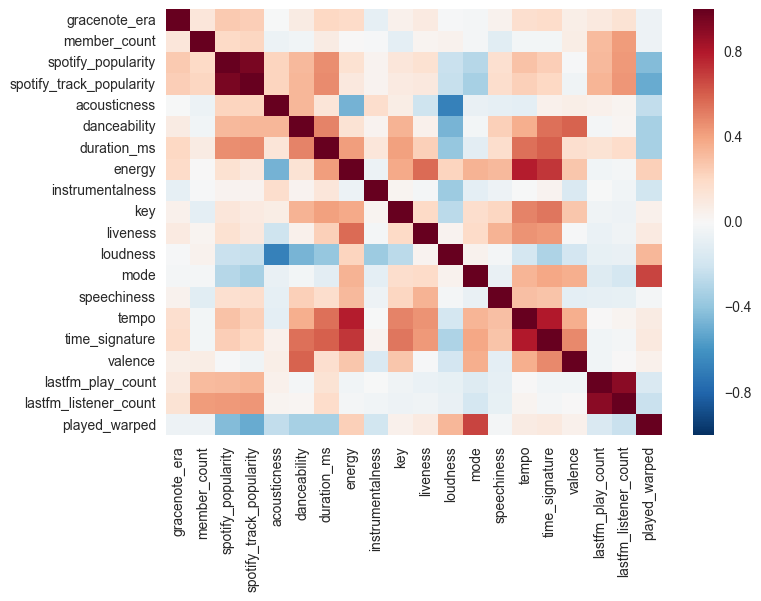

In [23]:
print 'Coorelations'
print all_data.corr()
print "\n" "\n"

print 'Coorelations Heatmap'
print sns.heatmap(all_data.corr())
print "\n" "\n"